array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bd88950>,
      dtype=object)

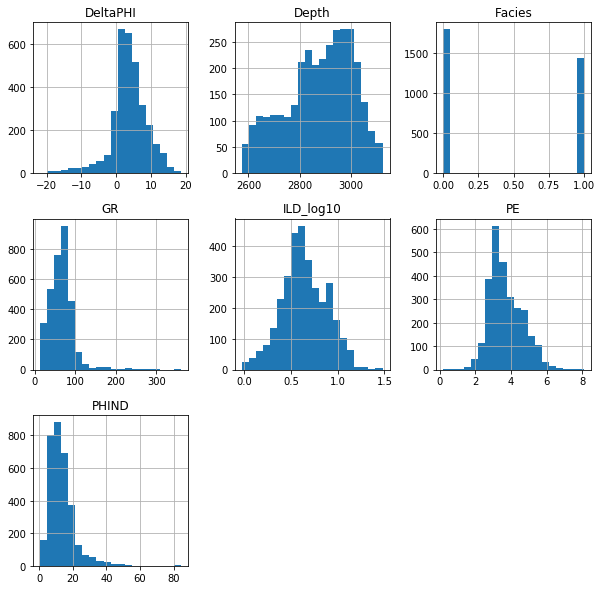

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

training_data = pd.read_csv('/Users/kimginam/ML-Resources-Development/Data/well_logs_Hall.csv')


training_data.hist(bins=20, figsize=(10,10))


In [25]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_data, test_size=0.2, random_state=10)

In [26]:
train_set["Facies"].value_counts() / len(train_set)

0    0.559381
1    0.440619
Name: Facies, dtype: float64

In [28]:
train_set, val_set = train_test_split(training_data, test_size=0.2, stratify=training_data['Facies'],
                                      random_state=10)

train_set["Facies"].value_counts() / len(train_set)

0    0.555513
1    0.444487
Name: Facies, dtype: float64

In [29]:
val_set["Facies"].value_counts() / len(val_set)

0    0.556414
1    0.443586
Name: Facies, dtype: float64

In [30]:
X_train_num_pd = train_set[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
X_train_cat_pd = train_set['NM_M']
y_train_np = train_set['Facies'].values
train_set_orig = train_set.copy()

In [31]:
X_train_num_pd[X_train_num_pd.isnull().any(axis=1)]

,GR,ILD_log10,DeltaPHI,PHIND,PE
2584,19.90,0.623,-7.7,11.45,NaN
2545,29.42,0.846,0.3,4.95,NaN
2771,45.19,0.787,4.5,8.95,NaN
2727,75.05,0.515,11.5,19.55,NaN
2766,25.62,0.826,0.7,6.25,NaN
...,...,...,...,...,...
2788,39.69,1.035,2.4,6.40,NaN
2655,34.45,0.753,2.9,5.75,NaN
2618,59.53,0.605,10.2,13.30,NaN
2485,61.49,0.805,2.5,5.95,NaN


In [32]:
median_PE = X_train_num_pd['PE'].median()
X_train_num_pd['PE'].fillna(median_PE, inplace=True)

In [33]:
X_train_num_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 2584 to 373
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GR         2585 non-null   float64
 1   ILD_log10  2585 non-null   float64
 2   DeltaPHI   2585 non-null   float64
 3   PHIND      2585 non-null   float64
 4   PE         2585 non-null   float64
dtypes: float64(5)
memory usage: 121.2 KB


In [38]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

X_train_num_np_cls = imputer.fit_transform(X_train_num_pd)

In [43]:
X_train_cat_np_encoded, X_train_cat_np_categories = X_train_cat_pd.factorize()
X_train_cat_np_encoded[:10]
X_train_cat_np_categories

Index(['M', 'NM'], dtype='object')

In [44]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_cat_1hot_sparse = encoder.fit_transform(X_train_cat_np_encoded.reshape(-1,1))
X_train_cat_1hot_sparse

<2585x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2585 stored elements in Compressed Sparse Row format>

In [48]:
X_train_cat_np = X_train_cat_1hot_sparse.toarray()
X_train_cat_np

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## CategoricalEncoder

In [46]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [49]:
cat_encoder = CategoricalEncoder()
X_train_cat_one_hot = cat_encoder.fit_transform(X_train_cat_pd.values.reshape(-1, 1))
X_train_cat_one_hot

<2585x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2585 stored elements in Compressed Sparse Row format>

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num_pd)
X_train = np.hstack((X_train_num_scaled, X_train_cat_np))

In [52]:
X_train.shape

(2585, 7)

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [54]:
attributes = ['NM_M']
selector = DataFrameSelector(attributes)
selector.fit_transform(train_set_orig)

array([['M'],
       ['M'],
       ['M'],
       ...,
       ['M'],
       ['M'],
       ['M']], dtype=object)

In [58]:
from sklearn.pipeline import Pipeline

num_attribs = ["GR", "ILD_log10", "DeltaPHI", "PHIND","PE"]
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer),
        ('std_scaler', StandardScaler()),
    ])

cat_attribs = ["NM_M"]
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [59]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [60]:
X_train = full_pipeline.fit_transform(train_set_orig)
X_val = full_pipeline.transform(val_set)

In [61]:
y_train = train_set_orig['Facies'].values
y_val = val_set['Facies'].values

In [64]:
from sklearn.linear_model import LogisticRegression

lgst_reg = LogisticRegression()
lgst_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
pred_lgst = lgst_reg.predict(X_val)

In [66]:
from sklearn.metrics import confusion_matrix
conf_lgst = confusion_matrix(y_val, pred_lgst)
conf_lgst

array([[325,  35],
       [ 10, 277]])

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('< Logistic Regression >')
print('Accuracy : ', accuracy_score(y_val, pred_lgst))
print('Precision: ', precision_score(y_val, pred_lgst))
print('Recall   : ', recall_score(y_val, pred_lgst))
print('f1_score : ', f1_score(y_val, pred_lgst))

< Logistic Regression >
Accuracy :  0.9304482225656878
Precision:  0.8878205128205128
Recall   :  0.9651567944250871
f1_score :  0.9248747913188647
